In [1]:
! pip install plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as skn

import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error , mean_absolute_percentage_error


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/CAP 2757 Final Project/NY-House-Dataset.csv')
df.columns

Index(['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [4]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [5]:
sel_cols = ['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE']
df = df[sel_cols]
df.head()


,TYPE,BEDS,BATH,PROPERTYSQFT,PRICE
0,Condo for sale,2,2.000000,1400.0,315000
1,Condo for sale,7,10.000000,17545.0,195000000
2,House for sale,4,2.000000,2015.0,260000
3,Condo for sale,3,1.000000,445.0,69000
4,Townhouse for sale,7,2.373861,14175.0,55000000


In [6]:
df.TYPE.unique()

array(['Condo for sale', 'House for sale', 'Townhouse for sale',
       'Co-op for sale', 'Multi-family home for sale', 'For sale',
       'Contingent', 'Land for sale', 'Foreclosure', 'Pending',
       'Coming Soon', 'Mobile house for sale', 'Condop for sale'],
      dtype=object)

In [7]:
df.TYPE.value_counts()

,count
TYPE,
Co-op for sale,1450
House for sale,1012
Condo for sale,891
Multi-family home for sale,727
Townhouse for sale,299
Pending,243
Contingent,88
Land for sale,49
For sale,20


In [8]:
keep_types = ['Co-op for sale' , 'House for sale' , 'Condo for sale' , 'Multi-family home for sale']
df = df[df.TYPE.isin(keep_types)]

df.describe()

,BEDS,BATH,PROPERTYSQFT,PRICE
count,4080.000000,4080.000000,4080.000000,4.080000e+03
mean,3.250490,2.278291,2074.843823,2.178840e+06
std,2.666289,1.943583,2383.280016,3.391084e+07
min,1.000000,1.000000,250.000000,4.950000e+04
25%,2.000000,1.000000,1130.000000,4.727500e+05
50%,3.000000,2.000000,2184.207862,7.990000e+05
75%,4.000000,3.000000,2184.207862,1.385750e+06
max,50.000000,50.000000,65535.000000,2.147484e+09


In [9]:
lower_iqr = np.nanpercentile(df.PRICE , 10)
upper_iqr = np.nanpercentile(df.PRICE , 90)

iqr = upper_iqr - lower_iqr

lower_bound = lower_iqr - (1.5 * iqr)
upper_bound = upper_iqr + (1.5 * iqr)


df = df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_iqr)]

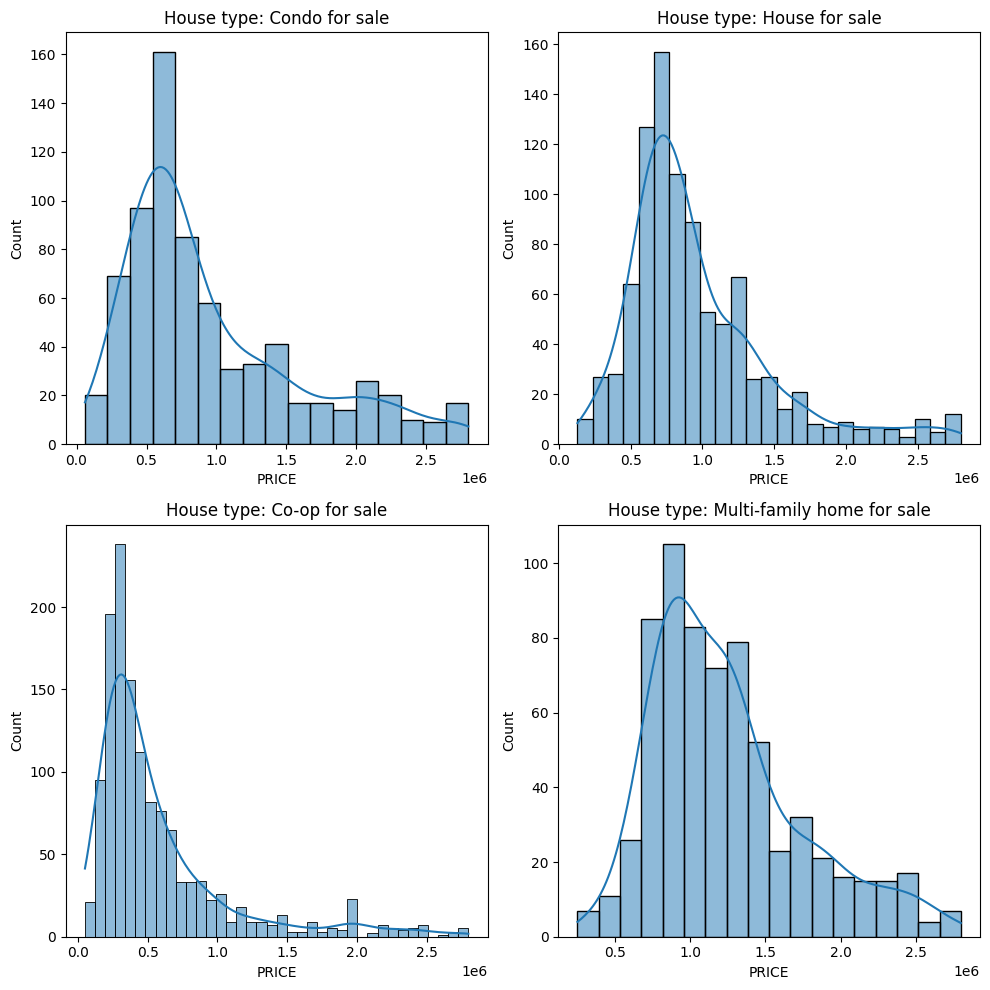

In [10]:
import seaborn as sns


house_types = df.TYPE.unique()

fig , axs = plt.subplots(2,2 , figsize = (10,10))

axs = axs.flatten()

for i in range(len(house_types)):
    sns.histplot(
        data=df[df["TYPE"] == house_types[i]],
        x="PRICE",
        kde=True,
        ax=axs[i]
    )
    axs[i].set_title(f"House type: {house_types[i]}")

plt.tight_layout()
plt.show()

In [11]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE')

fig.show()



In [12]:

from scipy.stats import ttest_ind
import itertools

house_types = df["TYPE"].unique()

res = []

# Compare all pairs of house types
for a, b in itertools.combinations(house_types, 2):
    prices_a = df[df["TYPE"] == a]["PRICE"]
    prices_b = df[df["TYPE"] == b]["PRICE"]
    t_stat, p_val = ttest_ind(prices_a, prices_b, equal_var=False)  # Welch’s t-test
    temp = {
        "comparison": f"{a} vs {b}",
        "t-stat": t_stat,
        "p-value": p_val
    }
    res.append(temp)

res = pd.DataFrame(res)

res

,comparison,t-stat,p-value
0,Condo for sale vs House for sale,-0.007742,9.938240e-01
1,Condo for sale vs Co-op for sale,14.431310,1.085762e-43
2,Condo for sale vs Multi-family home for sale,-8.932790,1.314940e-18
3,House for sale vs Co-op for sale,18.450973,2.375655e-70
4,House for sale vs Multi-family home for sale,-10.719927,7.565290e-26
5,Co-op for sale vs Multi-family home for sale,-28.007003,6.488954e-136


In [13]:
df.shape[0]

3677